In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


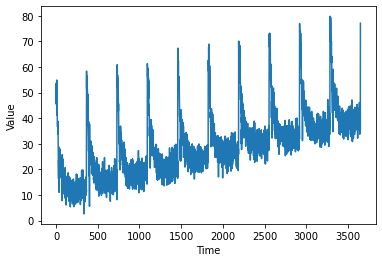

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 5 * np.pi),
                    1 / np.exp( 8 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, .1)  
baseline = 10
amplitude = 40
slope = 0.008
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

Desired output -- a chart that looks like this:

![Chart showing upward trend and seasonailty](http://www.laurencemoroney.com/wp-content/uploads/2019/07/plot1.png)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), metrics=['acc'])
history = model.fit(dataset,epochs=100,verbose=1, callbacks=[lr_scheduler])


Epoch 1/100
94/94 [==============================] - 0s 4ms/step - loss: 642.3162 - acc: 0.0000e+00 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 343.9609 - acc: 0.0000e+00 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 0s 4ms/step - loss: 186.4836 - acc: 0.0000e+00 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 104.1091 - acc: 0.0000e+00 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 65.2080 - acc: 0.0000e+00 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 49.1534 - acc: 0.0000e+00 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 43.1850 - acc: 0.0000e+00 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 0s 4ms/step - loss: 41.1354 - acc: 0.0000e+00 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - l

(1e-08, 0.001, 0.0, 300.0)

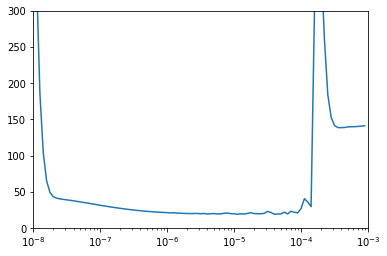

In [6]:
losses = history.history['loss']
lrs = 1e-8 * 10**(np.arange(100) / 20)
plt.semilogx(lrs, losses)
plt.axis([1e-8, 1e-3, 0, 300])

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9), metrics=['acc'])
history = model.fit(dataset,epochs=500,verbose=1)


Epoch 1/500
94/94 [==============================] - 0s 4ms/step - loss: 60.6127 - acc: 0.0000e+00
Epoch 2/500
94/94 [==============================] - 0s 4ms/step - loss: 22.4407 - acc: 0.0000e+00
Epoch 3/500
94/94 [==============================] - 0s 4ms/step - loss: 21.3463 - acc: 0.0000e+00
Epoch 4/500
94/94 [==============================] - 0s 4ms/step - loss: 20.6757 - acc: 0.0000e+00
Epoch 5/500
94/94 [==============================] - 0s 4ms/step - loss: 20.3392 - acc: 0.0000e+00
Epoch 6/500
94/94 [==============================] - 0s 4ms/step - loss: 20.3949 - acc: 0.0000e+00
Epoch 7/500
94/94 [==============================] - 0s 3ms/step - loss: 20.4687 - acc: 0.0000e+00
Epoch 8/500
94/94 [==============================] - 0s 3ms/step - loss: 20.4315 - acc: 0.0000e+00
Epoch 9/500
94/94 [==============================] - 0s 4ms/step - loss: 20.6530 - acc: 0.0000e+00
Epoch 10/500
94/94 [==============================] - 0s 4ms/step - loss: 20.1644 - acc: 0.0000e+00
Epoch 11/

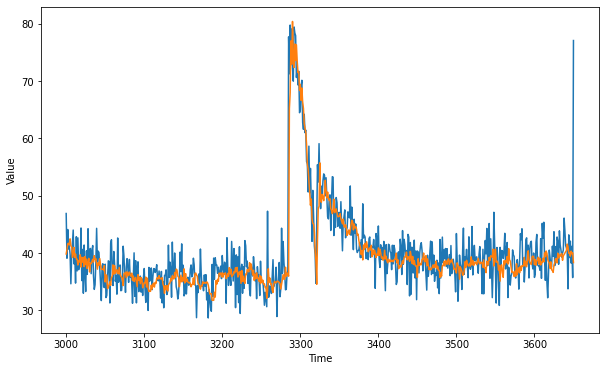

In [8]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

2.791277